In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging 
import os

# Set logging level
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [24]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip',origin=URL,extract=True)

In [25]:
base_dir = os.path.join(os.path.dirname(zip_dir),'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

In [26]:
train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

In [27]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_eval = len(os.listdir(validation_cats_dir))
num_dogs_eval = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr +  num_dogs_tr
total_val = num_cats_eval + num_dogs_eval

In [28]:
print('Total training cat images: ',num_cats_tr)
print('Total training dog images',num_dogs_tr)

print('Total validation cat images: ',num_cats_eval)
print('Total validation dog images: ',num_dogs_eval)

print('---------------')

print("Total training images: ",total_train)
print("Total validation images: ",total_val)

Total training cat images:  1000
Total training dog images 1000
Total validation cat images:  500
Total validation dog images:  500
---------------
Total training images:  2000
Total validation images:  1000


In [29]:
BATCH_SIZE = 100
IMG_SHAPE = 150

In [30]:
# This function will plot images 
def plot_images(images):
  fig , axes = plt.subplots(1,5,figsize=(20,20))
  axes = axes.flatten()
  for img,ax in zip(images,axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

### Rotating the image

In [31]:
image_gen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


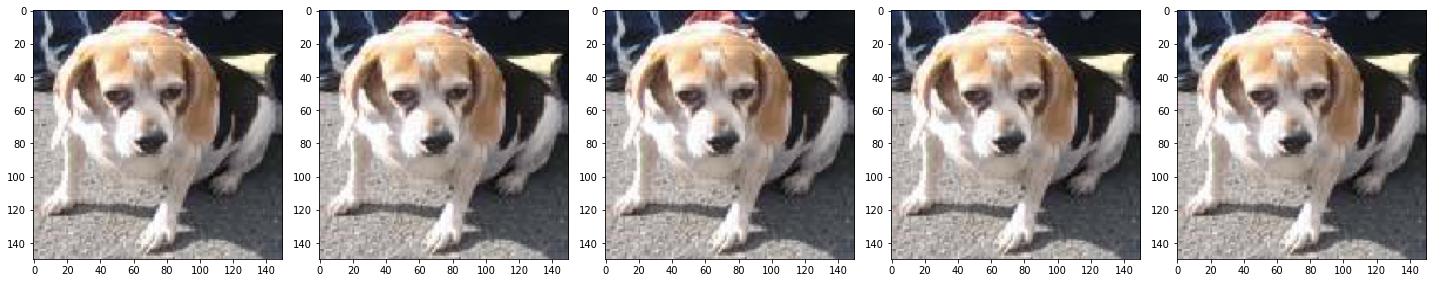

In [32]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

In [33]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


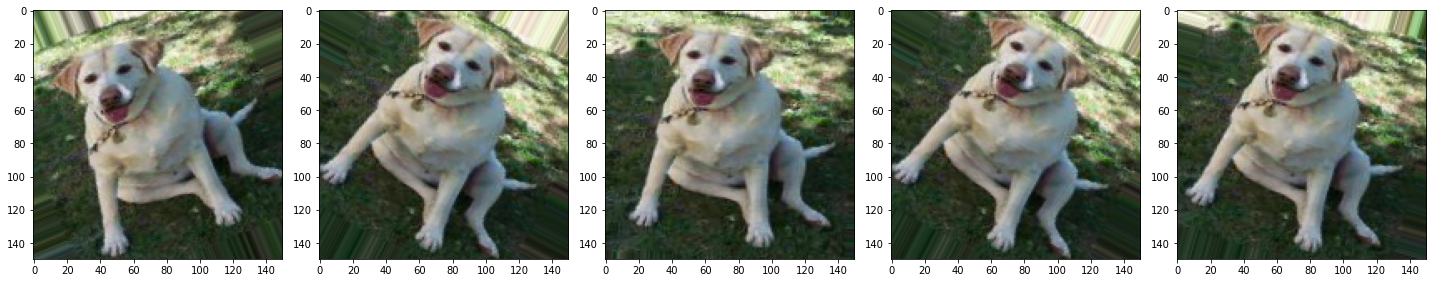

In [34]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

### Applying Zoom

In [35]:
# image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.5)

# train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
#                                                directory=train_dir,
#                                                shuffle=True,
#                                                target_size=(IMG_SHAPE,IMG_SHAPE))

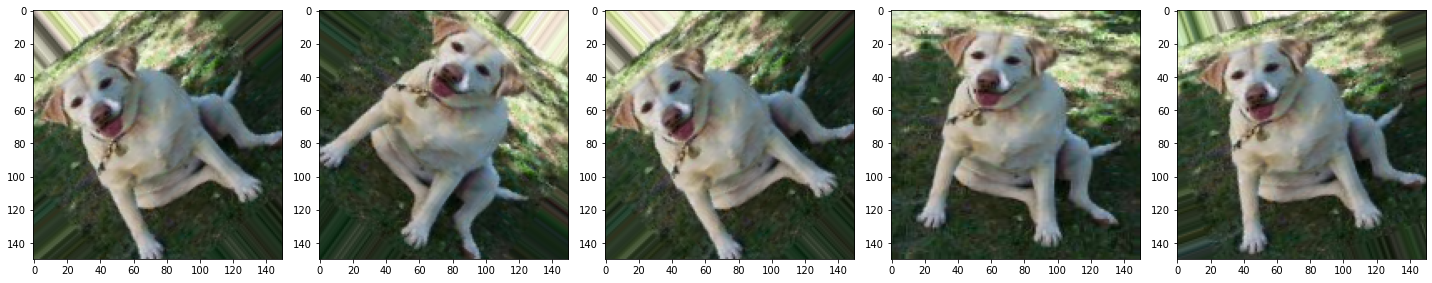

In [36]:
# augmented_images = [train_data_gen[0][0][0] for i in range(5)]
# plot_images(augmented_images)

# Putting all the changes together

In [37]:
image_gen_train = ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 40 ,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode='nearest'
) 
train_data_gen = image_gen_train.flow_from_directory(batch_size = BATCH_SIZE,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


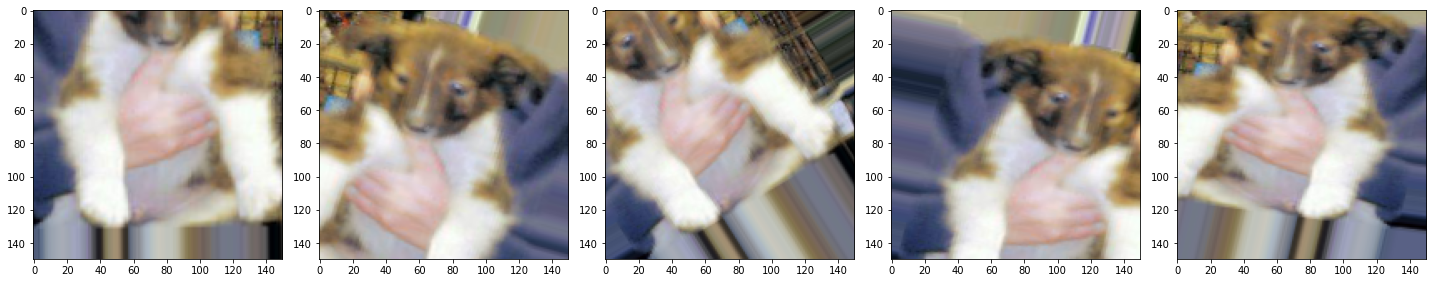

In [38]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

In [39]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Model creation


In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

## Training the model

In [43]:
%%time

EPOCHS = 100

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')
]

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    callbacks = my_callbacks,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)


Epoch 1/100
20/20 [==============================] - 17s 832ms/step - loss: 1.3692 - accuracy: 0.4163 - val_loss: 0.7763 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 16s 811ms/step - loss: 0.7062 - accuracy: 0.5251 - val_loss: 0.7007 - val_accuracy: 0.5000
Epoch 3/100
20/20 [==============================] - 16s 822ms/step - loss: 0.6976 - accuracy: 0.5193 - val_loss: 0.6888 - val_accuracy: 0.5770
Epoch 4/100
20/20 [==============================] - 16s 819ms/step - loss: 0.6893 - accuracy: 0.5403 - val_loss: 0.6838 - val_accuracy: 0.5320
Epoch 5/100
20/20 [==============================] - 16s 809ms/step - loss: 0.6824 - accuracy: 0.5518 - val_loss: 0.6722 - val_accuracy: 0.5550
Epoch 6/100
20/20 [==============================] - 16s 805ms/step - loss: 0.6814 - accuracy: 0.5575 - val_loss: 0.6510 - val_accuracy: 0.6140
Epoch 7/100
20/20 [==============================] - 16s 814ms/step - loss: 0.6697 - accuracy: 0.5979 - val_loss: 0.6347 - val_accuracy:

Total training accuracy : 0.777999997138977
Total validation accuracy : 0.7960000038146973


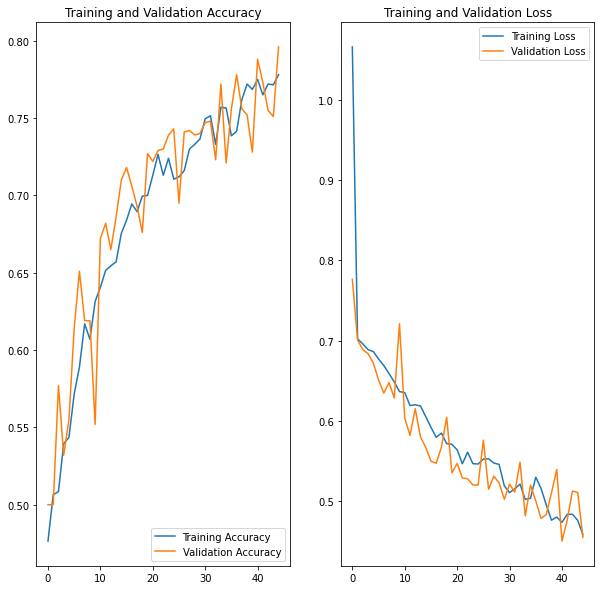

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Total training accuracy :",max(acc))
print("Total validation accuracy :",max(val_acc))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()